In [17]:
import sys
import os

# 添加 src 到路径，便于导入
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), "../src")))

%matplotlib widget
import matplotlib.pyplot as plt

import json

from shapely.geometry import Point, Polygon, LineString, box
import math
import numpy as np
import re
from rich import print

# 自定义模块导入
from display_class import *
from CADAlgo.check import *
from CADAlgo.generate import *
from CADAlgo.parser import *

In [18]:
with open("传参数\\N02主视图.json", "r", encoding="utf-8") as f:
    data = json.load(f)

schema = parse_schema(data)
schema.schema_name = "_N02_front_view"

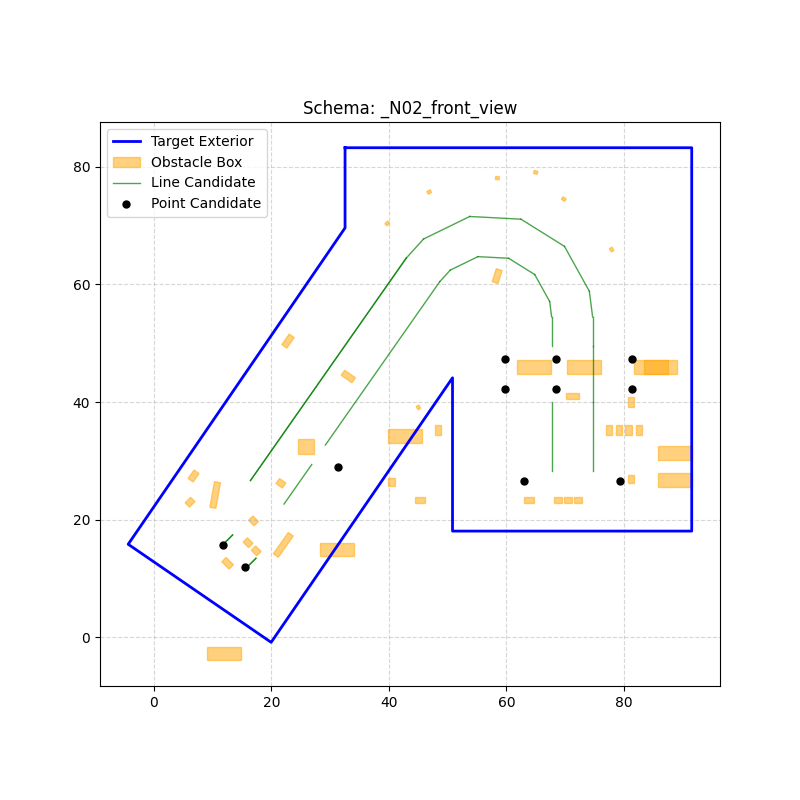

In [19]:
_, _ = plot_schema(schema)

In [20]:
candidates = schema.point_candidates
exterior = schema.target_exterior
obstacles = [obstacle_box.geometry for obstacle_box in schema.obstacle_boxes]
samples_distance = 5
lines = generate_connection_lines_from_point_candidates(
    candidates,[], exterior, obstacles, dispel_lines=[], samples_distance=samples_distance
)

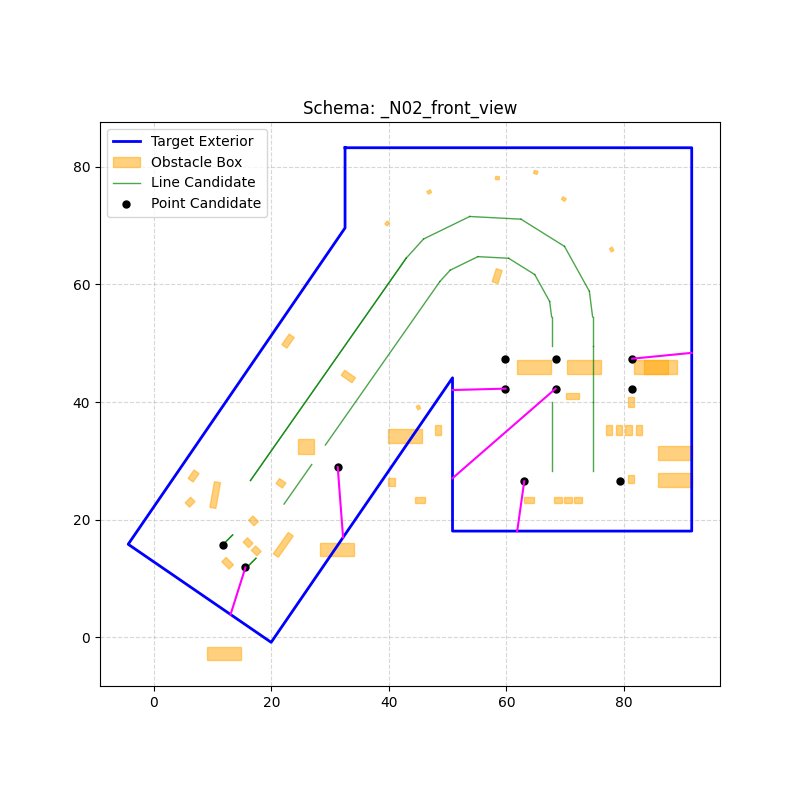

In [21]:
fig, ax = plot_schema(schema)

# 连接线
for line in lines:
    x_line, y_line = line.xy
    ax.plot(x_line, y_line, color="magenta", linewidth=1.5)

**解析障碍物盒子**

In [22]:
with open("block_boxes.txt", "r", encoding="utf-8") as f:
    raw_data = f.read()

# 解析每一行
obstacle_boxes = []

for line in raw_data.splitlines():
    # 找出每行的四个坐标点
    matches = re.findall(r"\((-?\d+(?:\.\d+)?),\s*(-?\d+(?:\.\d+)?)\)", line)
    if len(matches) != 4:
        raise Exception("没有四个!")

    # 转为 float
    points = [(float(x), float(y)) for x, y in matches]

    # 构造 box 对象
    box = {
        "a": {"x": points[0][0], "y": points[0][1]},
        "b": {"x": points[1][0], "y": points[1][1]},
        "c": {"x": points[2][0], "y": points[2][1]},
        "d": {"x": points[3][0], "y": points[3][1]},
    }

    obstacle_boxes.append(box)

# 最终结果
block_boxes_result = {"obstacle_box": obstacle_boxes}
block_boxes_result_json = json.dumps(block_boxes_result, indent=2)
# print(block_boxes_result)

**解析障碍物线**

In [23]:
import json
import re

barrier_lines = []

with open("block_lines.txt", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue  # 跳过空行

        # 匹配一行中的两个点
        match = re.match(r"\(([^,]+),\s*([^)]+)\),\s*\(([^,]+),\s*([^)]+)\)", line)
        if match:
            x1, y1, x2, y2 = map(float, match.groups())
            barrier_lines.append({"x1": x1, "y1": y1, "x2": x2, "y2": y2})
        else:
            print(f"格式不匹配: {line}")

obstacle_box_result = {"barrier_line": barrier_lines}

# 输出 JSON 字符串，格式化缩进
obstacle_box_result_str = json.dumps(obstacle_box_result, indent=2, ensure_ascii=False)

# print(obstacle_box_result_str)

In [24]:
points = []

with open("box_edges.txt", "r", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue

        # 匹配 (x, y)
        match = re.match(r"\(([^,]+),\s*([^)]+)\)", line)
        if match:
            x_str, y_str = match.groups()
            point = {"x": float(x_str), "y": float(y_str)}
            points.append(point)
        else:
            print(f"格式不匹配: {line}")

# 生成目标结构
exterior_result_dict = {"target_exterior": points}

# 输出为格式化 JSON 字符串
json_str = json.dumps(exterior_result_dict, indent=2, ensure_ascii=False)
# print(exterior_result_dict)

In [25]:
with open("parts.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()

lines = raw_text.strip().splitlines()
part_data = {"line_candidates": [], "point_candidates": []}

i = 0
while i < len(lines):
    header_match = re.match(r"(\d+)\s+(\d+)\s+(\d+)", lines[i])
    if not header_match:
        i += 1
        continue

    part_index, point_count, line_count = map(int, header_match.groups())
    part_name = f"零件{part_index}"
    i += 1

    if point_count > 0:
        points = []
        for _ in range(point_count):
            point_match = re.findall(r"\(([^)]+)\)", lines[i])
            if point_match:
                x, y = map(float, point_match[0].split(","))
                points.append({"x": x, "y": y})
            i += 1
        part_data["point_candidates"].append({"part_name": part_name, "points": points})

    elif line_count > 0:
        lines_list = []
        for _ in range(line_count):
            line_match = re.findall(r"\(([^)]+)\)", lines[i])
            if len(line_match) == 2:
                x1, y1 = map(float, line_match[0].split(","))
                x2, y2 = map(float, line_match[1].split(","))
                lines_list.append({"x1": x1, "y1": y1, "x2": x2, "y2": y2})
            i += 1
        part_data["line_candidates"].append(
            {"part_name": part_name, "lines": lines_list}
        )

# 构建最终 JSON 结构
part_output_dict = {"part": part_data}

# 显示为字符串（可选：保存为文件）
# print(json.dumps(part_output_dict, indent=2, ensure_ascii=False))

In [26]:
final_result_dict = {
    "schema_name": "_N11_front_view",
    **block_boxes_result,
    **obstacle_box_result,
    **exterior_result_dict,
    **part_output_dict,
}
# print(final_result_dict)

In [27]:
with open("result.json", "w", encoding="utf-8") as f:
    json.dump(final_result_dict, f, ensure_ascii=False, indent=2)

In [28]:
schema = parse_schema(final_result_dict)

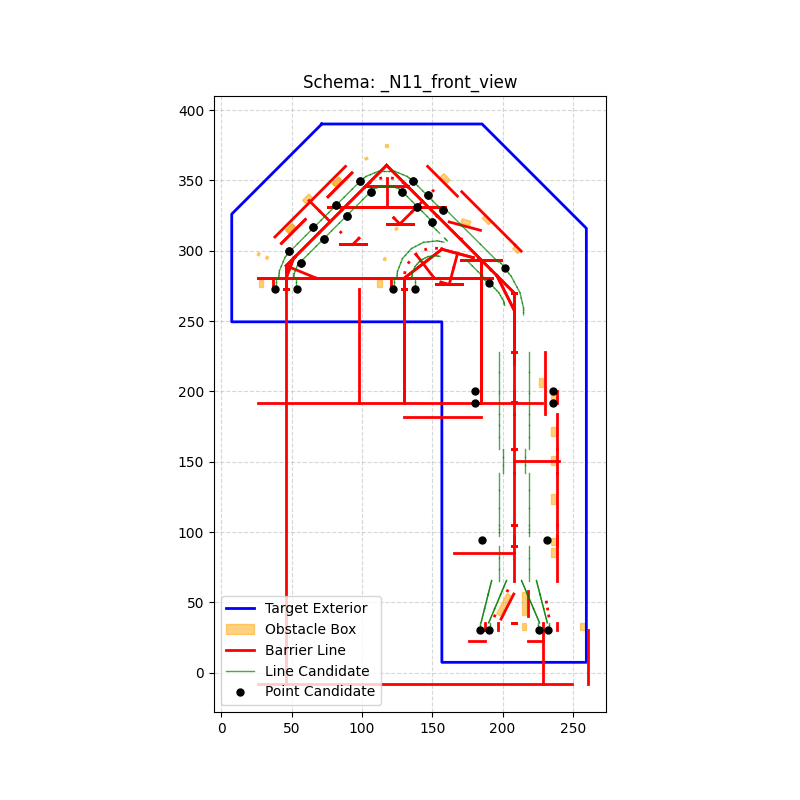

In [29]:
_, _ = plot_schema(schema)

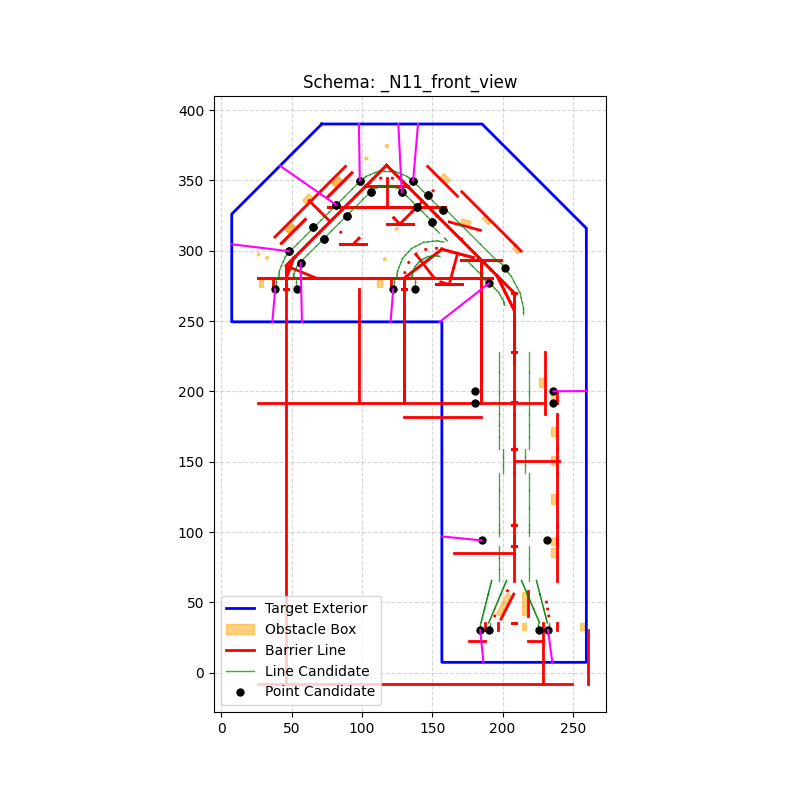

In [30]:
candidates = schema.point_candidates
exterior = schema.target_exterior
obstacles = [obstacle_box.geometry for obstacle_box in schema.obstacle_boxes]
samples_distance = 7
lines = generate_connection_lines_from_point_candidates(
    candidates,[], exterior, obstacles,dispel_lines=[], samples_distance=samples_distance
)

fig, ax = plot_schema(schema)

# 连接线
for line in lines:
    x_line, y_line = line.xy
    ax.plot(x_line, y_line, color="magenta", linewidth=1.5)

(<Figure size 800x600 with 1 Axes>, <Axes: >)

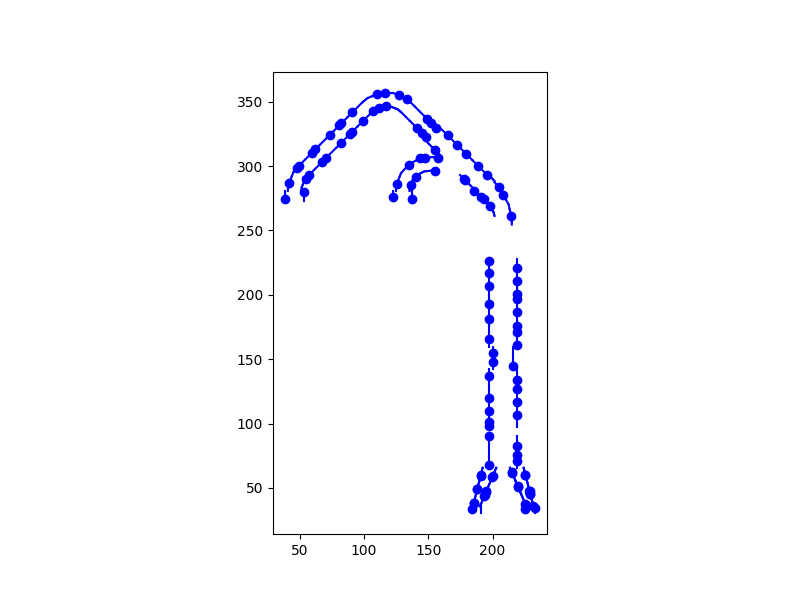

In [31]:
line_candidate: list[LineString] = []
for my_line in schema.line_candidates[:]:
    for l in my_line.lines:
        line_candidate.append(l.geometry)

line_point_samples = interpolate_whole_path(line_candidate, 10)

plot_geometries([*line_candidate, *line_point_samples])

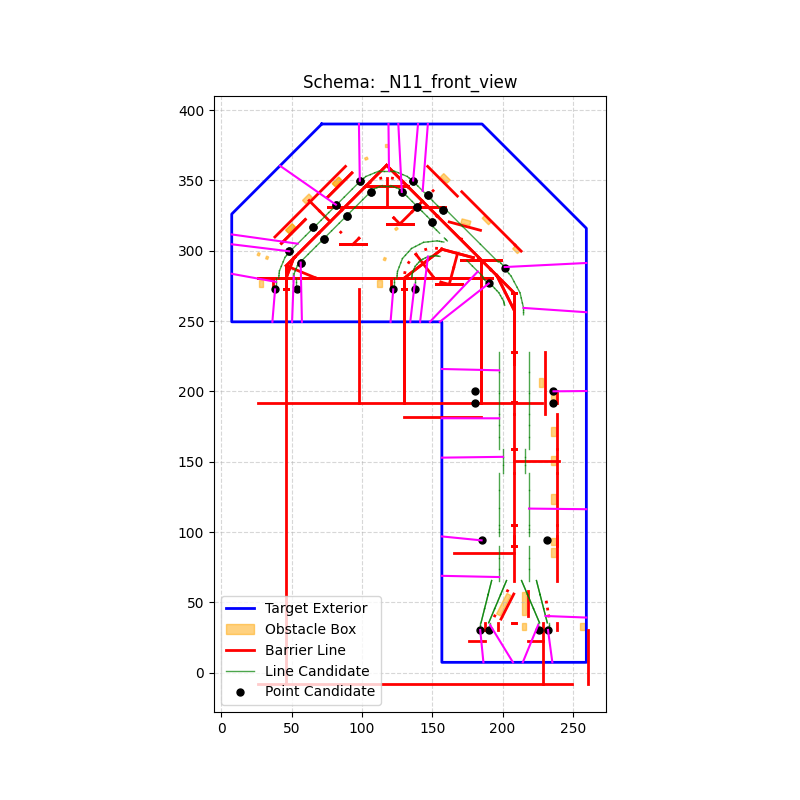

In [32]:
candidates = schema.point_candidates

exterior = schema.target_exterior
obstacles = [obstacle_box.geometry for obstacle_box in schema.obstacle_boxes]
samples_distance = 7
lines = generate_connection_lines_from_point_candidates(
    candidates, schema.line_candidates, exterior, obstacles,dispel_lines=[], samples_distance=samples_distance
)

fig, ax = plot_schema(schema)

# 连接线
for line in lines:
    x_line, y_line = line.xy
    ax.plot(x_line, y_line, color="magenta", linewidth=1.5)